In [62]:
import torch
import os
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader,WeightedRandomSampler
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.functional import relu
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import train_test_split
import numpy as np

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

colors = {
    'Train': '#007AFF',  # Apple Blue
    'Test': '#FF9500'    # Apple Orange
}

device = 'cuda'
path_to_pt_ekyn = f'../pt_ekyn'

Series 1 - Mean: 1.2789769243681803e-17 Std Dev: 1.0
Series 2 - Mean: 5.684341886080802e-18 Std Dev: 1.0


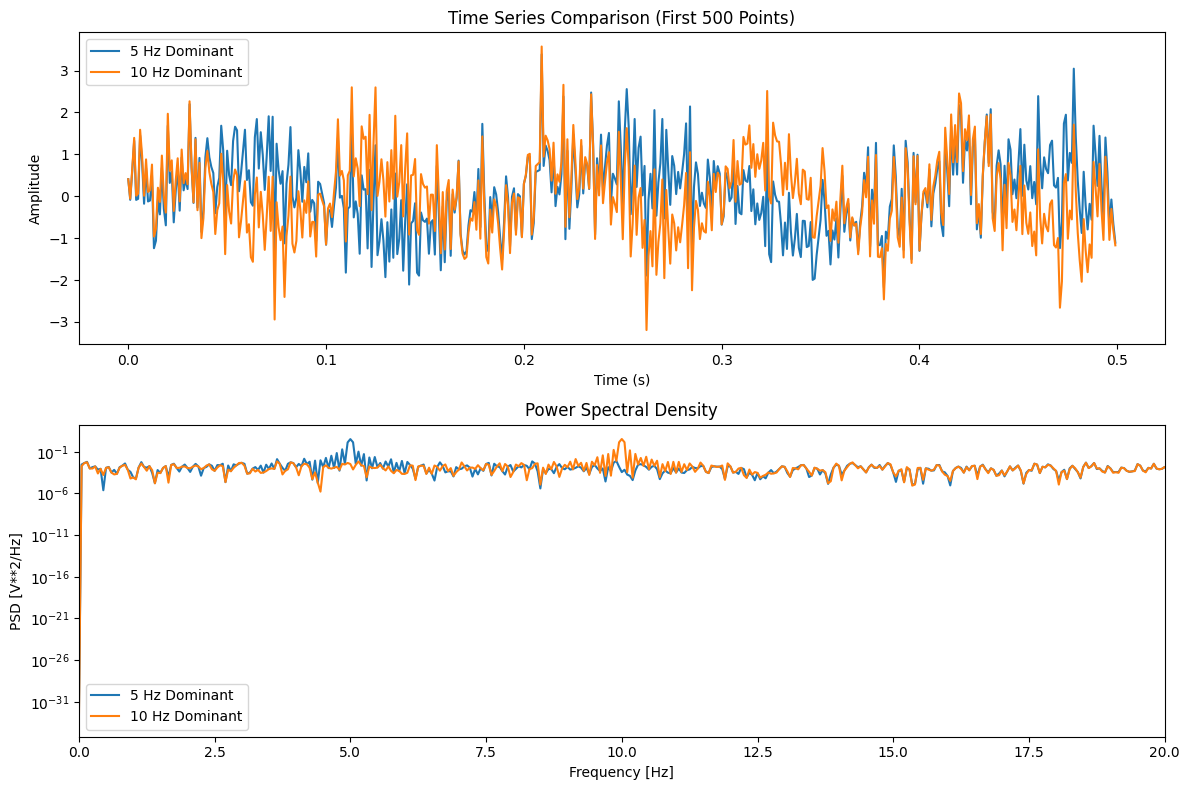

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Set a seed for reproducibility
np.random.seed(42)

# Parameters
n_points = 10000  # Increased points for better resolution
mean = 0
std_dev = 1
sampling_rate = 1000  # Increased sampling rate for better frequency resolution
time = np.linspace(0, n_points/sampling_rate, n_points)

# Generate base noise
base_noise = np.random.normal(loc=mean, scale=std_dev, size=n_points)

# Series 1: Add a strong 5 Hz component
amplitude_5Hz = 1.0  # Strong amplitude for 5 Hz
series1 = base_noise + amplitude_5Hz * np.sin(2 * np.pi * 5 * time)

# Series 2: Add a strong 10 Hz component
amplitude_10Hz = 1.0  # Strong amplitude for 10 Hz
series2 = base_noise + amplitude_10Hz * np.sin(2 * np.pi * 10 * time)

# Normalize both series to have the same mean and std_dev
def normalize(series, target_mean, target_std):
    current_mean = np.mean(series)
    current_std = np.std(series)
    return (series - current_mean) / current_std * target_std + target_mean

series1 = normalize(series1, mean, std_dev)
series2 = normalize(series2, mean, std_dev)

# Verify statistical properties
print("Series 1 - Mean:", np.mean(series1), "Std Dev:", np.std(series1))
print("Series 2 - Mean:", np.mean(series2), "Std Dev:", np.std(series2))

# Plotting to visualize the difference in frequency components
plt.figure(figsize=(12, 8))

# Time Domain
plt.subplot(2, 1, 1)
plt.plot(time[:500], series1[:500], label='5 Hz Dominant')  # Show only first 500 points for clarity
plt.plot(time[:500], series2[:500], label='10 Hz Dominant')
plt.title('Time Series Comparison (First 500 Points)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

# Frequency Domain - Power Spectral Density
plt.subplot(2, 1, 2)
f, Pxx_spec1 = signal.periodogram(series1, fs=sampling_rate, window='boxcar', nfft=n_points*2)  # Increased nfft for better resolution
f, Pxx_spec2 = signal.periodogram(series2, fs=sampling_rate, window='boxcar', nfft=n_points*2)
plt.semilogy(f, Pxx_spec1, label='5 Hz Dominant')
plt.semilogy(f, Pxx_spec2, label='10 Hz Dominant')
plt.xlim(0, 20)  # Focus on a smaller range to see peaks clearly
plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()

plt.tight_layout()
plt.show()

<Axes: ylabel='Density'>

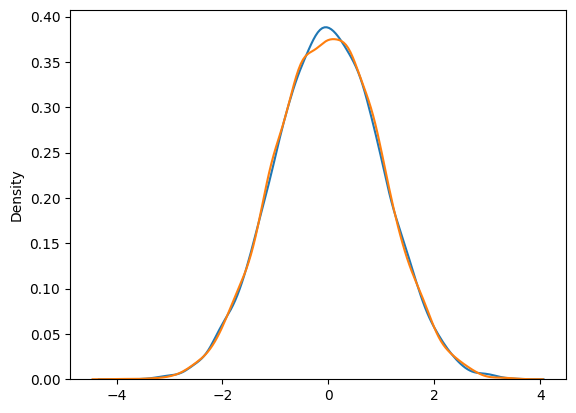

In [61]:
sns.kdeplot(series1)
sns.kdeplot(series2)

In [54]:
(series1 ** 2).sum()
(series2 ** 2).sum()

np.float64(1000.0)

(2e-05, 0.00014)

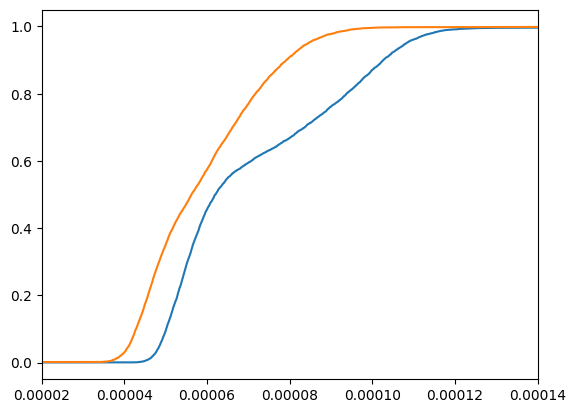

In [ ]:
import numpy as np
import torch

def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

X,y = torch.load(f'{path_to_pt_ekyn}/{recording_filenames[0]}')
# Example data
x, y = ecdf(X.std(dim=1))
plt.plot(x,y)

X,y = torch.load(f'{path_to_pt_ekyn}/{recording_filenames[1]}')
x, y = ecdf(X.std(dim=1))
plt.plot(x,y)

plt.xlim([.00002,.00014])

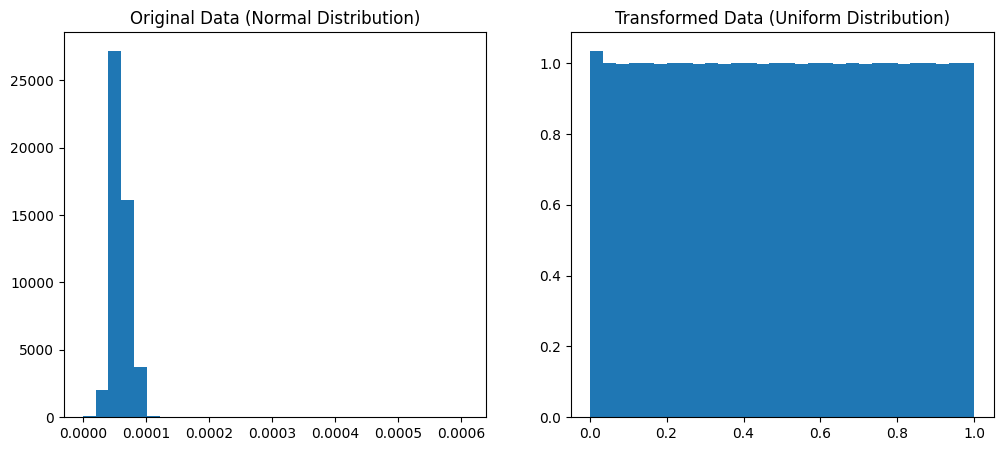

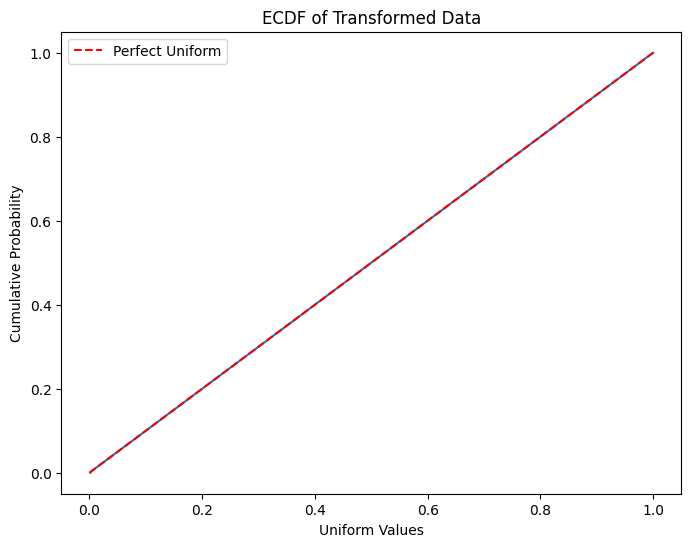

Mean of uniform data: 0.5001
Variance of uniform data: 0.0833


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def ecdf(data):
    """
    Compute the Empirical Cumulative Distribution Function (ECDF) for the given data.
    
    :param data: numpy array of data points
    :return: tuple of sorted data points and their corresponding ECDF values
    """
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def ecdf_value(x, data):
    """
    Compute the ECDF value for a given x in the context of the data distribution.
    
    :param x: The value for which to compute the ECDF
    :param data: The data set
    :return: ECDF value, a number between 0 and 1
    """
    return np.searchsorted(data, x, side='right') / len(data)

def integral_transform_to_uniform(data):
    """
    Perform the integral transform to convert data to uniform distribution.
    
    :param data: Input data array
    :return: Transformed data to approximate uniform distribution
    """
    # Sort data for ECDF computation
    sorted_data = np.sort(data)
    
    # Compute ECDF for each data point
    uniform_transformed = np.array([ecdf_value(val, sorted_data) for val in data])
    
    # To handle potential exact 0 or 1, we clip the results slightly
    uniform_transformed = np.clip(uniform_transformed, 1e-10, 1 - 1e-10)
    
    return uniform_transformed

# Example data
np.random.seed(42)  # for reproducibility
data = X.std(dim=1)

# Perform the integral transform to uniform
uniform_data = integral_transform_to_uniform(data)

# Visualize the transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, density=True)
plt.title('Original Data (Normal Distribution)')
plt.subplot(1, 2, 2)
plt.hist(uniform_data, bins=30, density=True)
plt.title('Transformed Data (Uniform Distribution)')
plt.show()

# Check the transformation by plotting the empirical CDF of the transformed data
uniform_ecdf_x, uniform_ecdf_y = ecdf(uniform_data)
plt.figure(figsize=(8, 6))
plt.plot(uniform_ecdf_x, uniform_ecdf_y)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Uniform')  # Reference line for perfect uniform
plt.title('ECDF of Transformed Data')
plt.xlabel('Uniform Values')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

# Print some statistics to confirm uniform distribution
print(f"Mean of uniform data: {np.mean(uniform_data):.4f}")
print(f"Variance of uniform data: {np.var(uniform_data):.4f}")

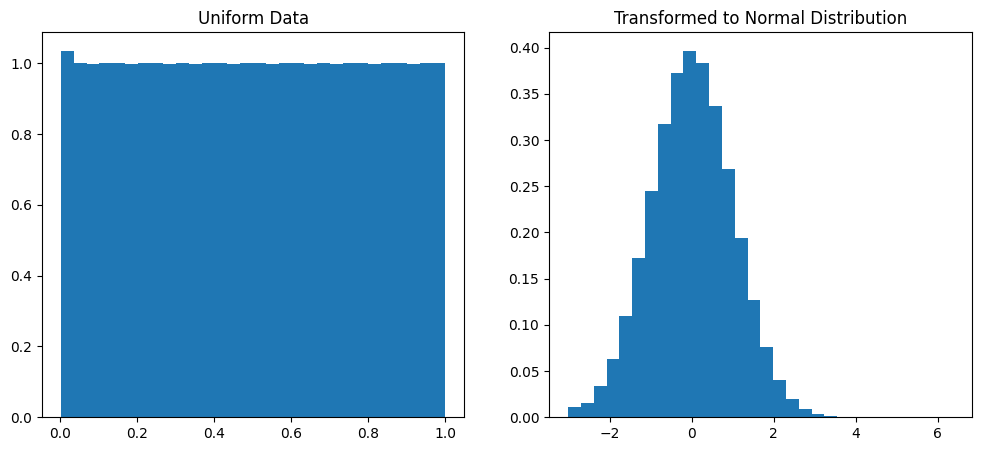

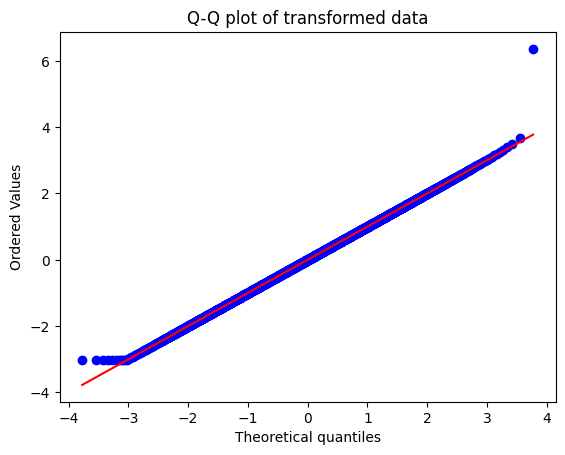

Mean of normal data: 0.0010
Standard Deviation of normal data: 1.0004


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def uniform_to_normal(uniform_data, mean=0, std_dev=1):
    """
    Transform uniform data to normal distribution using the inverse CDF of the normal distribution.
    
    :param uniform_data: Data uniformly distributed on [0, 1]
    :param mean: Mean of the desired normal distribution
    :param std_dev: Standard deviation of the desired normal distribution
    :return: Data transformed to normal distribution
    """
    # Use scipy.stats.norm.ppf for the inverse CDF of the normal distribution
    # We subtract 0.5 from uniform_data to center the transformation around zero before scaling
    normal_data = stats.norm.ppf(uniform_data, loc=mean, scale=std_dev)
    
    return normal_data

# Example data (simulating uniform distribution)
np.random.seed(42)  # for reproducibility

# Transform uniform to normal
normal_data = uniform_to_normal(uniform_data)

# Visualize the transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(uniform_data, bins=30, density=True)
plt.title('Uniform Data')
plt.subplot(1, 2, 2)
plt.hist(normal_data, bins=30, density=True)
plt.title('Transformed to Normal Distribution')
plt.show()

# Plotting the Q-Q plot to check normality
from scipy import stats

stats.probplot(normal_data, dist="norm", plot=plt)
plt.title('Q-Q plot of transformed data')
plt.show()

# Print some statistics to confirm normal distribution
print(f"Mean of normal data: {np.mean(normal_data):.4f}")
print(f"Standard Deviation of normal data: {np.std(normal_data):.4f}")

(-0.0005, 0.0005)

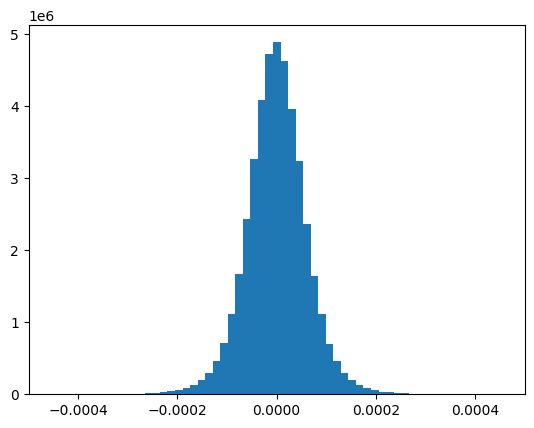

In [12]:
plt.hist(X.flatten(),bins=200)
plt.xlim([-.0005,.0005])

(-1e-05, 1e-05)

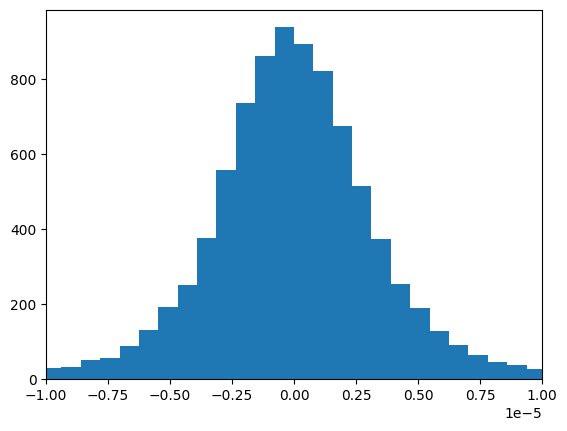

In [18]:
plt.hist(X.mean(dim=1),bins=1000);
plt.xlim([-.00001,.00001])

(0.0, 0.0002)

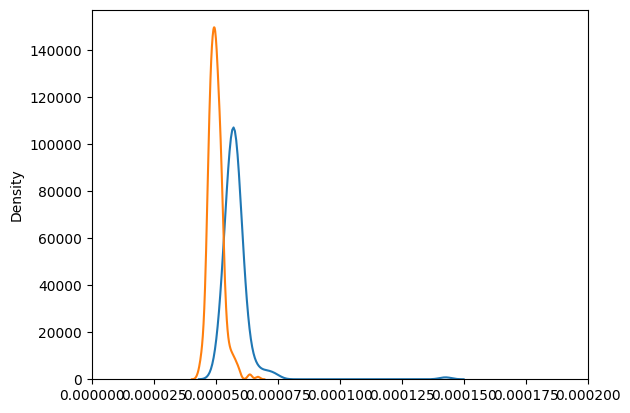

In [82]:
X,y = torch.load(f'{path_to_pt_ekyn}/{recording_filenames[10]}')
sns.kdeplot(X[torch.where(y.argmax(axis=1) == 0)[0]].std(dim=1));

X,y = torch.load(f'{path_to_pt_ekyn}/{recording_filenames[11]}')
sns.kdeplot(X[torch.where(y.argmax(axis=1) == 0)[0]].std(dim=1));

# sns.kdeplot(X[torch.where(y.argmax(axis=1) == 1)[0]].std(dim=1));
# sns.kdeplot(X[torch.where(y.argmax(axis=1) == 2)[0]].std(dim=1));
plt.xlim([0,.0002])

In [108]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

def ecdf_value(x, data):
    return np.searchsorted(data, x, side='right') / len(data)

def integral_transform_to_uniform(data):
    sorted_data = np.sort(data)
    return np.array([ecdf_value(val, sorted_data) for val in data])

def uniform_to_normal(uniform_data, mean=0, std_dev=1):
    return stats.norm.ppf(uniform_data, loc=mean, scale=std_dev)

# Example 2D data
np.random.seed(42)
data = X.clone()  # 1000 samples, 2 features

# Step 1: Compute standard deviations for dimension 2 grouped by dimension 1
stds = data.std(dim=1)

In [109]:

# Step 2: Transform these standard deviations to uniform
uniform_stds = integral_transform_to_uniform(stds)

# Step 3: Transform uniform standard deviations to normal
# Here, we assume we want a standard normal distribution for simplicity
normal_stds = uniform_to_normal(uniform_stds)

# Step 4: Scale and shift data in dimension 2 to match new standard deviations
# For each sample, we'll adjust dimension 2
normal_stds

array([-0.32291547, -0.10842647, -0.62574611, ..., -0.0043518 ,
       -0.36974289, -0.31741869])

Original std of dimension 2: 1.0103
New std of dimension 2: nan


ValueError: supplied range of [-3.0902323722839355, inf] is not finite

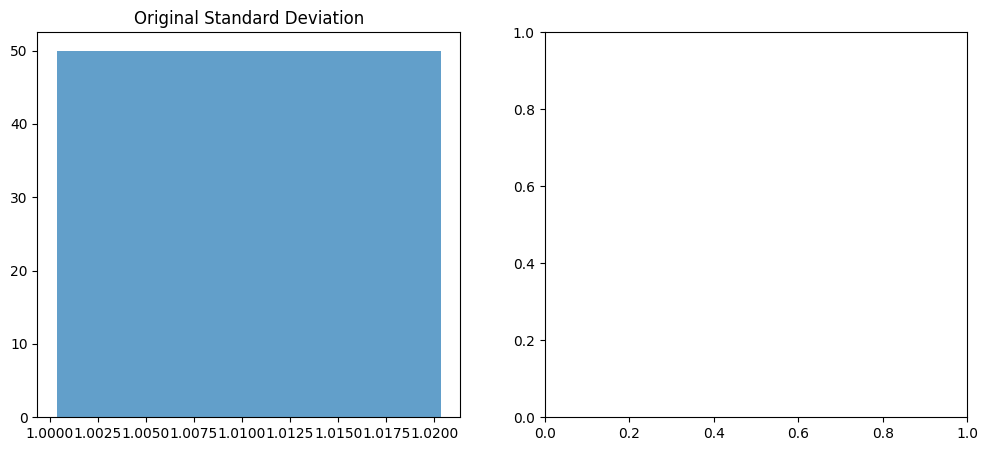

In [123]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats

# Example 2D data using PyTorch for tensor operations
torch.manual_seed(42)
data = torch.randn(1000, 2)  # 1000 samples, 2 features

# Compute standard deviations for dimension 2 grouped by dimension 1
stds = torch.std(data[:, 1])  # Standard deviation of dimension 2 across all samples

# Transform these standard deviations to uniform
uniform_stds = torch.tensor([torch.searchsorted(torch.sort(data[:, 1])[0], x, right=True).item() / data.size(0) for x in data[:, 1]])

# Clip uniform values to avoid edge cases
uniform_stds = torch.clamp(uniform_stds, min=1e-10, max=1 - 1e-10)

# Transform uniform standard deviations to normal
normal_stds = stats.norm.ppf(uniform_stds.numpy(), loc=0, scale=1)  # Convert to numpy for scipy

# Convert back to tensor for PyTorch operations
normal_stds = torch.tensor(normal_stds)

# Scale and shift data in dimension 2 to match new standard deviations
new_data = data.clone()
for i in range(data.shape[0]):
    # Compute how much to scale dimension 2 for this sample
    scale_factor = normal_stds[i] / stds
    new_data[i, 1] = data[i, 1] * scale_factor  # Scale dimension 2

# Verify the transformation
new_stds = torch.std(new_data[:, 1])  # New standard deviation across dimension 2
print(f"Original std of dimension 2: {stds:.4f}")
print(f"New std of dimension 2: {new_stds:.4f}")

# Visualize the transformation of standard deviations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(stds.item(), bins=[stds.item()-0.01, stds.item()+0.01], density=True, alpha=0.7)  # Since stds is a single value for all data
plt.title('Original Standard Deviation')
plt.subplot(1, 2, 2)
plt.hist(normal_stds.numpy(), bins=30, density=True, alpha=0.7)
plt.title('Transformed Standard Deviations (Normal)')
plt.show()

# Plot the transformed data to see if the distribution

In [ ]:


X = X.unsqueeze(1)
X = X[:,:,::10] # 500 Hz -> 50 Hz

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=512,shuffle=True)
testloader = DataLoader(TensorDataset(X_test,y_test),batch_size=512,shuffle=True)

Xi,yi = next(iter(trainloader))
print(Xi.shape,yi.shape,yi.argmax(dim=1).bincount())

Xi,yi = next(iter(testloader))
print(Xi.shape,yi.shape,yi.argmax(dim=1).bincount())

In [ ]:
class SimpleNorm(nn.Module):
    def __init__(self,eps):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.shift = nn.Parameter(torch.tensor(0.0))
    def forward(self,x):
        mean = x.flatten().mean()
        std = x.flatten().std()
        x = (x - mean) / (std + self.eps)
        return x * self.scale + self.shift
    
class CNNSleepStager(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.norm = SimpleNorm(1e-5)
        self.c1 = nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7)

        self.mp = nn.MaxPool1d(kernel_size=2)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(in_features=64,out_features=3)
    def forward(self,x):
        x = self.norm(x)
        x = self.c1(x)
        x = relu(x)
        x = self.mp(x)
        x = self.gap(x)
        x = x.squeeze()
        x = self.classifier(x)
        return x
    
model = CNNSleepStager()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-3)
criterion = nn.CrossEntropyLoss()
model.to(device)

In [ ]:
import numpy as np
window_size = 10
def moving_average(data, window_size=10):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

colors = {
    'Train': '#007AFF',  # Apple Blue
    'Test': '#FF9500'    # Apple Orange
}

trainlossi = []
testlossi = []

validation_frequency_epochs = 20

for epoch in tqdm(range(50000)):
    for Xi,yi in trainloader:
        Xi,yi = Xi.to(device),yi.to(device)
        optimizer.zero_grad()
        logits = model(Xi)
        loss = criterion(logits,yi)
        loss.backward()
        optimizer.step()
        trainlossi.append(loss.item())

    if epoch % validation_frequency_epochs == 0:
        # Calculate Test Loss
        with torch.no_grad():
            testlossi.append(torch.hstack([criterion(model(Xi.to(device)),yi.to(device)).cpu() for Xi,yi in testloader]).mean().item())

        # Plot Loss
        plt.figure()

        # First subplot - Loss
        plt.plot(trainlossi, label='Train Loss', color=colors['Train'], alpha=0.4, linewidth=1.5)
        
        # Moving average for loss
        if len(trainlossi) > window_size:
            plt.plot(range(window_size-1, len(trainlossi)), moving_average(trainlossi, window_size), label='Train Loss MA', color=colors['Train'], linestyle='--', linewidth=1.5)

        plt.plot(torch.linspace(0,len(trainlossi),len(testlossi)),testlossi, label='Test Loss', color=colors['Test'], alpha=1, linewidth=1.5)
        plt.savefig('loss.jpg')
        plt.close()

In [ ]:
# Plot Loss
plt.figure()

# First subplot - Loss
plt.plot(trainlossi, label='Train Loss', color=colors['Train'], alpha=0.4, linewidth=1.5)

# Moving average for loss
if len(trainlossi) > window_size:
    plt.plot(range(window_size-1, len(trainlossi)), moving_average(trainlossi, window_size), label='Train Loss MA', color=colors['Train'], linestyle='--', linewidth=1.5)

plt.plot(torch.linspace(0,len(trainlossi),len(testlossi)),testlossi, label='Test Loss', color=colors['Test'], alpha=1, linewidth=1.5)

In [ ]:
y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).cpu(),yi.argmax(dim=1)]).T for Xi,yi in trainloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))

y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).cpu(),yi.argmax(dim=1)]).T for Xi,yi in testloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))